<a href="https://colab.research.google.com/github/avs20/GNoidaMLBatch/blob/master/SVHN_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/RyannnG/Capstone-Google-SVHN-Digits-Recognition



https://ryannng.github.io/2016/12/20/Street-View-House-Numbers-Recognition-Using-ConvNets/


https://github.com/penny4860/SVHN-deep-digit-detector
https://github.com/potterhsu/SVHNClassifier

https://github.com/penny4860/SVHN-deep-digit-detector


In [0]:

# These are all the modules we'll be using later.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io   
import h5py

import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image

from scipy import ndimage

import random

from collections import Counter

%matplotlib inline

Download training and testing sets from http://ufldl.stanford.edu/housenumbers/

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat

--2019-09-29 15:17:10--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  52.6MB/s    in 4.4s    

2019-09-29 15:17:15 (39.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-09-29 15:17:17--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  23.9MB/s    in 2.6s    

2019-09-29 15:17:20 (23.9 MB/s) - ‘test_32x32.mat’ saved [64275384/64

Load and convert the data to pickle format. 

In [3]:
# load train/test dataset
train_data = scipy.io.loadmat('./train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('./train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('./test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('./test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('./extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('./extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 531131) (531131, 1)


Which labels are present?

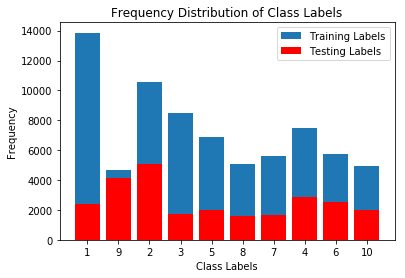

In [6]:
"""
Plotting Class Labels against their respective frequencies in a Bar Graph
"""
temp_labels = train_labels.reshape(73257).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', label='Training Labels')
plt.xticks(range(len(temp_labels)), temp_labels.keys())
temp_labels = test_labels.reshape(26032).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='red', label='Testing Labels')
plt.legend()
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')
plt.show()

Transform the dataset to required format

In [7]:
train_dataset = train_data.transpose((3,0,1,2))
train_label = train_labels[:,0]
test_dataset = test_data.transpose((3,0,1,2))
test_label = test_labels[:,0]
extra_dataset = extra_data.transpose((3,0,1,2))
extra_label = extra_labels[:,0]


print(train_dataset.shape, train_label.shape)
print(test_dataset.shape, test_label.shape)
print(extra_dataset.shape, extra_label.shape)

(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)
(531131, 32, 32, 3) (531131,)


In [0]:
# create a validation dataset, 4/5 of data from train dataset , 1/5 from extra dataset
valid_size = 6000  
train_portion = 4000
extra_portion = 2000

In [9]:
valid_dataset = np.concatenate((train_dataset[:train_portion,:,:,:], extra_dataset[:extra_portion,:,:,:]))
valid_label = np.concatenate((train_label[:train_portion], extra_label[:extra_portion]))
train_dataset = train_dataset[train_portion:,:,:,:]
train_label = train_label[train_portion:]
                             
print(train_dataset.shape, train_label.shape)
print(test_dataset.shape, test_label.shape)
print(valid_dataset.shape, valid_label.shape)

(69257, 32, 32, 3) (69257,)
(26032, 32, 32, 3) (26032,)
(6000, 32, 32, 3) (6000,)


Randomize the datasets so that there is not any problem of same digits in same places


In [0]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_label = randomize(train_dataset, train_label)
test_dataset, test_label = randomize(test_dataset, test_label)
valid_dataset, valid_label = randomize(valid_dataset, valid_label)

Let's view some sample images

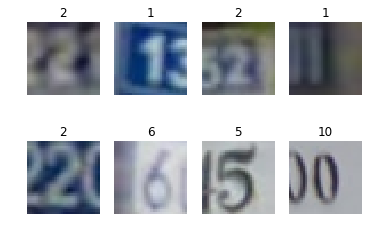

In [17]:
def disp_sample_dataset(dataset, label, cmap=""):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i])
        if cmap =="gray":
          plt.imshow(dataset[i],cmap=cmap)
        else:
          plt.imshow(dataset[i])
          

        
disp_sample_dataset(train_dataset, train_label)


There are single images in the dataset. The middle one is the main one. 
0 is represented by 10. 

### Saving the data to pickle file. 


In [0]:
pickle_file = 'SVHN_single_ori.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_label': train_label,
    'valid_dataset': valid_dataset,
    'valid_label': valid_label,
    'test_dataset': test_dataset,
    'test_label': test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

Let's read it and see if it's properly saved 

In [13]:
pickle_file = 'SVHN_single_ori.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (69257, 32, 32, 3) (69257,)
Validation set (6000, 32, 32, 3) (6000,)
Test set (26032, 32, 32, 3) (26032,)


The numbers match. See the images again 

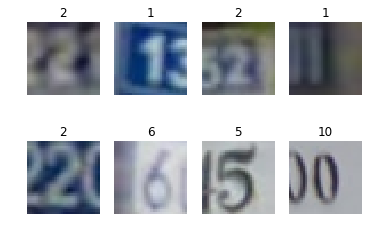

In [14]:
disp_sample_dataset(train_dataset, train_label)


These are single numbers. So preprocessing for grayscale 

### Converting to grayscale

In [15]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_dataset)[:,:,:,0]
test_data_c = im2gray(test_dataset)[:,:,:,0]
valid_data_c = im2gray(valid_dataset)[:,:,:,0]

print(train_data_c.shape, train_label.shape)
print(test_data_c.shape, test_label.shape)
print(valid_data_c.shape, valid_label.shape)


(69257, 32, 32) (69257,)
(26032, 32, 32) (26032,)
(6000, 32, 32) (6000,)


We go from 3d images to 2d (grayscale) images.

Let's see the images again 

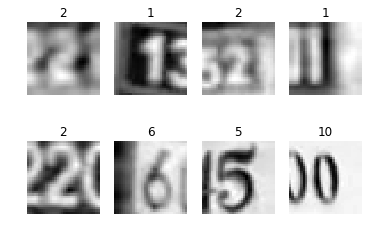

In [18]:
disp_sample_dataset(train_data_c, train_label, cmap="gray")


#### Saving the grayscale data

In [0]:
pickle_file = 'SVHN_single_grey.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data_c,
    'train_label': train_label,
    'valid_dataset': valid_data_c,
    'valid_label': valid_label,
    'test_dataset': test_data_c,
    'test_label': test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise